In [1]:
from ipywidgets import widgets
from IPython.display import display, clear_output
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

def update_theme(change):
    """ display chosen theme from dropdown menu """
    name = change['new']
    html_css = set_nb_theme(name)
    display(html_css)

themes = get_themes()
theme_sel = widgets.Dropdown(options=themes, description='Select a Theme:')
theme_sel.observe(update_theme, names=['selected_label'], type='change')

In [24]:
# start with first theme in themes list
display(theme_sel)
set_nb_theme(themes[4])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [17]:
# imports
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries which we'll use just
# to produce some visualizations of our training
#from libs.utils import montage
#from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

## Reading MPII Data

From MPII website:
    
    - Annotation description

Annotations are stored in a matlab structure RELEASE having following fields

    - .annolist(imgidx) - annotations for image imgidx
        - .image.name - image filename
            - .annorect(ridx) - body annotations for a person ridx
                - .x1, .y1, .x2, .y2 - coordinates of the head rectangle
                - .scale - person scale w.r.t. 200 px height
                - .objpos - rough human position in the image
                - .annopoints.point - person-centric body joint annotations
                    - .x, .y - coordinates of a joint
                    - id - joint id (0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
                - is_visible - joint visibility
            - .vidx - video index in video_list
            - .frame_sec - image position in video, in seconds
        - img_train(imgidx) - training/testing image assignment
        - single_person(imgidx) - contains rectangle id ridx of sufficiently separated individuals
        - act(imgidx) - activity/category label for image imgidx
            - act_name - activity name
            - cat_name - category name
            - act_id - activity id
        - video_list(videoidx) - specifies video id as is provided by YouTube. To watch video on youtube go to https://www.youtube.com/watch?v=video_list(videoidx)

Problem - Where are the annotations for the validation data?

In [10]:
filepath = '/mnt/data/datasets/MPII_HumanPose/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'
mpii_dataset_mat = scipy.io.loadmat(filepath, struct_as_record=False,squeeze_me=True)['RELEASE']

Number of training images:

In [67]:
mpii_dataset_mat.annolist[0].annorect

An example from the validation set:

In [27]:
print(mpii_dataset_mat.img_train[0])

0


In [29]:
mpii_dataset_mat.annolist[0].image.name

'037454012.jpg'

In [57]:
mpii_dataset_mat.annolist[0].annorect.annopoints.point

AttributeError: 'mat_struct' object has no attribute 'annopoints'

So, no annotations for the rest of the images - this must be testing data.

According to the paper http://human-pose.mpi-inf.mpg.de/contents/andriluka14cvpr.pdf the training set contains 28,821 annotated people and the test set contains 11,701 people

To get the data into our model we are going to serialize the data into a set of TFRecords. 
To make things easier to organize we first make a reading mechanism.
The MPII Data is a database of images of people with annotated body joint locations. Some images contain more than 1 person. The images are taken from YouTube videos which are also provided as part of the dataset.

The natural abstraction to make of the dataset is by having a class of people s.t. each person has a list of joints.

In [18]:
import sys
import os
import scipy.io
import numpy as np
from shapes import Rectangle
from tqdm import tqdm

In [8]:
class Joint(object):
    """Class to represent a joint, including x and y position and `is_visible`
    indicating whether the joint is visible or occluded.
    """
    def __init__(self, x, y, is_visible):
        self._x = x
        self._y = y
        self._is_visible = is_visible

    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y

    @property
    def is_visible(self):
        return self._is_visible

In [9]:
class Person(object):
    """A class representing each person in a given image, including their
    joints, objpos and scale.

    The joints should be a list of (x, y) tuples where x and y are both in the
    range [img_x_max, img_y_max], and the joint ids are as follows,

    0 - r ankle
    1 - r knee
    2 - r hip
    3 - l hip
    4 - l knee
    5 - l ankle
    6 - pelvis
    7 - thorax
    8 - upper neck
    9 - head top
    10 - r wrist
    11 - r elbow
    12 - r shoulder
    13 - l shoulder
    14 - l elbow
    15 - l wrist

    Attributes:
        joints: A list of 16 joints for the person, which all default to
            `None`. Their values are potentially filled in from the MPII
            dataset annotations.
        objpos: The approximate position of the center of the person in the
            image.
        scale: Scale of the person with respect to 200px.
    """
    NUM_JOINTS = 16

    def __init__(self, joints, objpos, scale, head_rect):
        self._joints = Person.NUM_JOINTS*[None]

        joints = _make_iterable(joints)

        for joint in joints:
            # NOTE(brendan): Only certain joints have the `is_visible`
            # annotation, and some images have no `is_visible` annotations at
            # all. Since the majority of joints are visible, we convert
            # unannotated joints to visible.
            # An experiment would be to try the opposite and compare results.
            if (type(joint.is_visible) is not int):
                is_visible = 1
            else:
                is_visible = joint.is_visible

            self._joints[joint.id] = Joint(joint.x, joint.y, is_visible)

        self._objpos = objpos
        self._scale = scale
        self._head_rect = head_rect

    @property
    def joints(self):
        return self._joints

    @property
    def objpos(self):
        return self._objpos

    @property
    def scale(self):
        return self._scale

    @property
    def head_rect(self):
        return self._head_rect


In [10]:
class MpiiDataset(object):
    """Representation of the entire MPII dataset.

    The annotation description can be found
    [here](http://human-pose.mpi-inf.mpg.de/#download).

    Currently only the images and person-centric body joint annotations are
    taken from the dataset.

    Attributes:
        img_filenames: A list of the names of the paths of each image.
        people_in_imgs: A list of lists of the `Person` class, where each list
            of `Person`s represents all the people in the image at the same
            list index. Must be the same length as `img_filenames`.
    """
    def __init__(self, img_filenames, people_in_imgs):
        assert len(img_filenames) == len(people_in_imgs)

        self._img_filenames = img_filenames
        self._people_in_imgs = people_in_imgs

    @property
    def img_filenames(self):
        return self._img_filenames

    @property
    def people_in_imgs(self):
        return self._people_in_imgs


We want to iterate through all the people in each image. In case there's only a single person the annorect structure in the .mat file is not represented by a list. We then make it into a list s.t. it can be iterated through.

In [11]:
def _make_iterable(maybe_iterable):
    """Checks whether `maybe_iterable` is iterable, and if not returns an
    iterable structure containing `maybe_iterable`.

    Args:
        maybe_iterable: An object that may or may not be iterable.

    Returns:
        maybe_iterable: If `maybe_iterable` was iterable, then it is returned,
        otherwise an iterable structure containing `maybe_iterable` is
        returned.
    """
    if not hasattr(maybe_iterable, '__iter__'):
        maybe_iterable = [maybe_iterable]

    return maybe_iterable


In [12]:
def _parse_annotation(img_annotation,
                      single_person_list,
                      mpii_images_dir,
                      is_train):
    """Parses a single image annotation from the MPII dataset.

    Looks at the annotations for a single image, and returns the people in the
    image along with the full filepath of the image.

    Args:
        img_annotation: The annotations coming from annolist(index) from the
            MPII dataset.
        single_person_list: List of MATLAB indices (starts from 1) of singular
            people in this image.
        mpii_images_dir: Path to the directory where the MPII images are.
        is_train: Training or test annotation? Training annotations require at
            least one joint to be annotated in order to be useful.

    Returns:
        img_abs_filepath: Filepath of the image corresponding to
            `img_annotation`.
        people: A list of `Person`s corresponding to the annotated people in
            the image.
    """
    img_abs_filepath = os.path.join(mpii_images_dir,
                                    img_annotation.image.name)

    img_annotation.annorect = _make_iterable(img_annotation.annorect)

    people = []
    for annorect_index in single_person_list:
        img_annorect = img_annotation.annorect[annorect_index - 1]

        try:
            objpos = img_annorect.objpos
            if (not hasattr(objpos, 'x')) or (not hasattr(objpos, 'y')):
                continue

            scale = img_annorect.scale
            assert scale > 0
        except AttributeError:
            continue

        try:
            head_rect = Rectangle((img_annorect.x1, img_annorect.y1,
                                   img_annorect.x2, img_annorect.y2))
            person = Person(img_annorect.annopoints.point,
                            objpos,
                            scale,
                            head_rect)
            people.append(person)
        except AttributeError:
            if is_train:
                continue

            people.append(Person([], objpos, scale))

    return img_abs_filepath, people


In [13]:
def _shuffle_list(list_l, shuffled_indices):
    """Shuffles list_l by re-ordering the list based on the indices in
    shuffled_indices.

    Args:
        list_l: List to be shuffled.
        shuffled_indices: Set of indices containing [0:len(list_l)), which is
            assumed to have already been shuffled.

    Returns:
        List with all the same elements as `list_l`, in the shuffled order given
        by `shuffled_indices`.
    """
    return [list_l[index] for index in shuffled_indices]




In [14]:
def _shuffle_dataset(img_filenames, people_in_imgs):
    """Shuffles the list of filenames and labels in the MPII dataset.

    Args:
        img_filenames: List of filenames in the MPII dataset to be shuffled.
        people_in_imgs: List of `Person`s in the MPII dataset, to be shuffled.
    """
    img_indices = list(range(len(img_filenames)))
    np.random.shuffle(img_indices)

    img_filenames = _shuffle_list(img_filenames, img_indices)
    people_in_imgs = _shuffle_list(people_in_imgs, img_indices)

    return img_filenames, people_in_imgs




In [15]:
def parse_mpii_data_from_mat(mpii_dataset_mat, mpii_images_dir, is_train):
    """Parses the training data out of `mpii_dataset_mat` into a `MpiiDataset`
    Python object.

    To save time during debugging sessions, you can manually get
    `mpii_dataset_mat` using `scipy.io.loadmat` once, and then iteratively call
    this function as you make changes, without reloading the .mat file.

    Args:
        mpii_dataset_mat: A dictionary of MATLAB structures loaded using
            `scipy.io.loadmat`. The arguments `struct_as_record = False` and
            `squeeze_me = True` must be set in the `loadmat` call.
        mpii_images_dir: The path of the directory where all the MPII images
            are stored.
        is_train: Parse training data (True), or test data (False)?

    Returns: An `MpiiDataset` Python object correspodning to
        `mpii_dataset_mat`.
    """
    mpii_annotations = mpii_dataset_mat.annolist
    train_or_test = mpii_dataset_mat.img_train

    img_filenames = []
    people_in_imgs = []
    filenames_on_disk = set(os.listdir(mpii_images_dir))
    for img_index in tqdm(range(len(mpii_annotations))):
        if train_or_test[img_index] == int(is_train):
            single_person_list = _make_iterable(mpii_dataset_mat.single_person[img_index])
            img_abs_filepath, people = _parse_annotation(mpii_annotations[img_index],
                                                         single_person_list,
                                                         mpii_images_dir,
                                                         is_train)
            if len(people) == 0:
                continue

            # NOTE(brendan): There are annotations in the MPII dataset for
            # which the file corresponding to image.name does not exist.
            # Therefore we have to check that the image is present before
            # adding it to our structure.
            if not os.path.basename(img_abs_filepath) in filenames_on_disk:
                continue

            img_filenames.append(img_abs_filepath)
            people_in_imgs.append(people)

    img_filenames, people_in_imgs = _shuffle_dataset(img_filenames,
                                                     people_in_imgs)

    return MpiiDataset(img_filenames, people_in_imgs)

In [16]:
def mpii_read(mpii_dataset_filepath, is_train):
    """
    Note that the images are assumed to reside in a folder one up from the .mat
    file that is being parsed (i.e. ../images).

    Args:
        mpii_dataset_filepath: The filepath to the .mat file provided from the
            MPII Human Pose website.
        is_train: Read training data (True), or test data (False)?

    Returns: Parsed `MpiiDataset` object from `parse_mpii_data_from_mat`.
    """
    mpii_dataset_mat = scipy.io.loadmat(mpii_dataset_filepath,
                                        struct_as_record=False,
                                        squeeze_me=True)['RELEASE']

    mpii_dataset_dir = os.path.dirname(mpii_dataset_filepath)
    mpii_images_dir = os.path.join(mpii_dataset_dir, '../images')

    return parse_mpii_data_from_mat(mpii_dataset_mat, mpii_images_dir, is_train)


In [20]:
path = '/mnt/data/datasets/MPII_HumanPose/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'

In [21]:
mpii_read(path, True)

100%|██████████| 24987/24987 [00:01<00:00, 13965.11it/s]


## Converting MPII Data into TFRecords

__main__.write_tf_record: 451.3931342980359


In [75]:
from skdata.mnist.views import OfficialVectorClassification

ImportError: No module named 'skdata'

In [ ]:
First calls the function mpii_read(filepath, is_train)


In [4]:
run write_tf_record.py

__main__.write_tf_record: 557.8946051700041


source: https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/

The second method, my preferred, is to do as much as I possibly can on the graph and to make use of binary files and input queues. Not only does this lighten the amount of code I need to write, removing the need to do any data augmentation or file reading, but the interface is reasonably standard across different kinds of data. It is also conceptually cleaner. No longer is there an artificial divide between preprocessing and model computation.

Import data using placeholders and feed_dicts:

Declare inputs and outputs

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

The shape argument to placeholder is optional, but it allows TensorFlow to automatically catch bugs stemming from inconsistent tensor shapes.

We start building the computation graph by creating nodes for the input images and target output classes.

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

A Variable is a value that lives in TensorFlow's computation graph. It can be used and even modified by the computation. In machine learning applications, one generally has the model parameters be Variables.

In [5]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

Before Variables can be used within a session, they must be initialized using that session. This step takes the initial values (in this case tensors full of zeros) that have already been specified, and assigns them to each Variable. This can be done for all Variables at once:

In [6]:
sess.run(tf.global_variables_initializer())

make model

In [15]:
# some convenience functions
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

3D volumes of neurons. Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth

Example Architecture: Overview. We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture [INPUT - CONV - RELU - POOL - FC]. In more detail:

INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.
RELU layer will apply an elementwise activation function, such as the max(0,x)max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.


The CONV layer’s parameters consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of a ConvNet might have size 5x5x3 (i.e. 5 pixels width and height, and 3 because images have depth 3, the color channels). During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. Now, we will have an entire set of filters in each CONV layer (e.g. 12 filters), and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

In [16]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Now that we have defined our model and training loss function, it is straightforward to train using TensorFlow. Because TensorFlow knows the entire computation graph, it can use automatic differentiation to find the gradients of the loss with respect to each of the variables. TensorFlow has a variety of built-in optimization algorithms. For this example, we will use steepest gradient descent, with a step length of 0.5, to descend the cross entropy.

In [9]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

What TensorFlow actually did in that single line was to add new operations to the computation graph. These operations included ones to compute gradients, compute parameter update steps, and apply update steps to the parameters.

The returned operation train_step, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step.

In [11]:
for i in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

We load 100 training examples in each training iteration. We then run the train_step operation, using feed_dict to replace the placeholder tensors x and y_ with the training examples. Note that you can replace any tensor in your computation graph using feed_dict -- it's not restricted to just placeholders.

evaluate model

In [12]:
#  gives us a list of booleans. 
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [13]:
# cast to floating point numbers and then take the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [14]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9171


The one important thing here is the order in which you construct your graph. TensorFlow’s sessions support running on separate threads. They do not support construction of the graph. This must happen on the main thread. In the example below I construct the CustomRunner on the main thread. Its constructor creates the necessary operations on the TensorFlow graph. These operations do not need a session at this point.

Another way of dealing with mnist data

In [2]:
from libs.datasets import MNIST
ds = MNIST()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
ds.X.shape

(70000, 784)

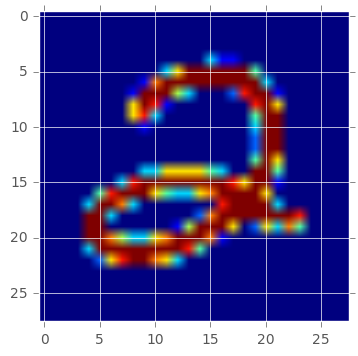

In [9]:
plt.imshow(ds.X[0].reshape((28,28)))

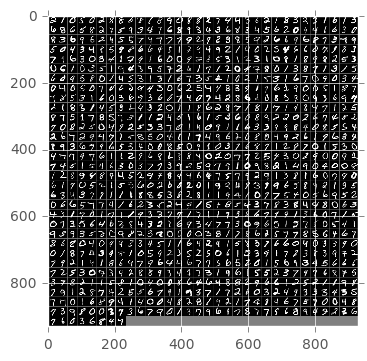

In [10]:
# Let's get the first 1000 images of the dataset and reshape them
imgs = ds.X[:1000].reshape((-1, 28, 28))

# Then create a montage and draw the montage
plt.imshow(montage(imgs), cmap='gray')

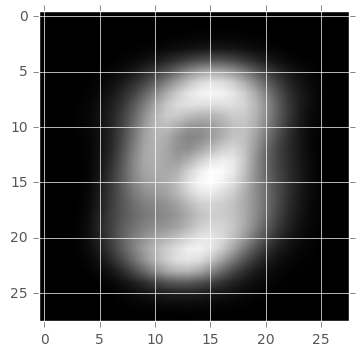

In [11]:
# Take the mean across all images
mean_img = np.mean(ds.X, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

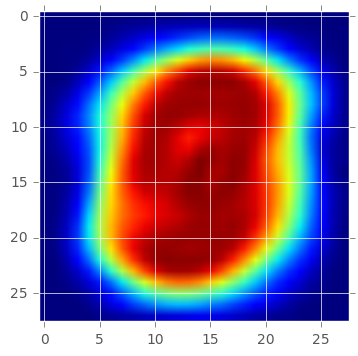

In [12]:
# Take the std across all images
std_img = np.std(ds.X, axis=0)

# Then plot the std image.
plt.figure()
plt.imshow(std_img.reshape((28, 28)))

## Fully Connected Model

In [17]:
# The dimensions of the layers
dimensions = [512, 256, 128, 64]

In [15]:
# So the number of features is the second dimension of our inputs matrix, 784
n_features = ds.X.shape[1]

# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

In [19]:
# let's first copy our X placeholder to the name current_input
current_input = X
n_input = n_features

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i),reuse=None):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [20]:
print(current_input.get_shape())

(?, 64)


In [21]:
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

[128, 256, 512, 784]


In [22]:
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [23]:
Y = current_input

In [24]:
# We'll first measure the average difference across every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [25]:
cost = tf.reduce_mean(cost)

In [26]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [28]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 0.0411115
1 0.0370884
2 0.0344161
3 0.0342275
4 0.0312809


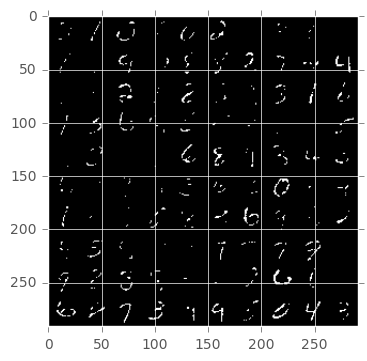

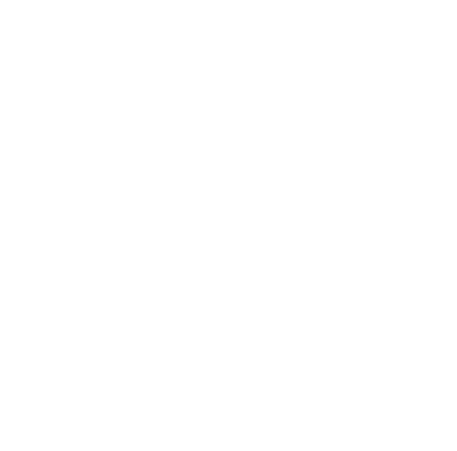

In [29]:
# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [31]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

## Indico data load scheme

In [34]:
import tensorflow as tf
import time
import threading
from skdata.mnist.views import OfficialVectorClassification
import numpy as np

# load data entirely into memory 🙁
data = OfficialVectorClassification()
trIdx = data.sel_idxs[:]
features = data.all_vectors[trIdx]
labels = data.all_labels[trIdx]

batch_size = 128
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, len(features))
        np.random.shuffle(idxs)
        shuf_features = features[idxs]
        shuf_labels = labels[idxs]
        for batch_idx in range(0, len(features), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx + batch_size] / 255.
            images_batch = images_batch.astype("float32")
            labels_batch = shuf_labels[batch_idx:batch_idx + batch_size]
            yield images_batch, labels_batch

class CustomRunner(object):
    """
    This class manages the the background threads needed to fill
        a queue full of data.
    """
    def __init__(self):
        self.dataX = tf.placeholder(dtype=tf.float32, shape=[None, 28*28])
        self.dataY = tf.placeholder(dtype=tf.int64, shape=[None, ])
        # The actual queue of data. The queue contains a vector for
        # the mnist features, and a scalar label.
        self.queue = tf.RandomShuffleQueue(shapes=[[28*28], []],
                                           dtypes=[tf.float32, tf.int64],
                                           capacity=2000,
                                           min_after_dequeue=1000)

        # The symbolic operation to add data to the queue
        # we could do some preprocessing here or do it in numpy. In this example
        # we do the scaling in numpy
        self.enqueue_op = self.queue.enqueue_many([self.dataX, self.dataY])

    def get_inputs(self):
        """
        Return's tensors containing a batch of images and labels
        """
        images_batch, labels_batch = self.queue.dequeue_many(128)
        return images_batch, labels_batch

    def thread_main(self, sess):
        """
        Function run on alternate thread. Basically, keep adding data to the queue.
        """
        for dataX, dataY in data_iterator():
            sess.run(self.enqueue_op, feed_dict={self.dataX:dataX, self.dataY:dataY})

    def start_threads(self, sess, n_threads=1):
        """ Start background threads to feed queue """
        threads = []
        for n in range(n_threads):
            t = threading.Thread(target=self.thread_main, args=(sess,))
            t.daemon = True # thread will close when parent quits
            t.start()
            threads.append(t)
        return threads

# Doing anything with data on the CPU is generally a good idea.
with tf.device("/cpu:0"):
    custom_runner = CustomRunner()
    images_batch, labels_batch = custom_runner.get_inputs()

# simple model
w = tf.get_variable("w1", [28*28, 10])
y_pred = tf.matmul(images_batch, w)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# for monitoring
loss_mean = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer().minimize(loss)

sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=8))
init = tf.initialize_all_variables()
sess.run(init)

# start the tensorflow QueueRunner's
tf.train.start_queue_runners(sess=sess)
# start our custom queue runner's threads
custom_runner.start_threads(sess)

while True:
    _, loss_val = sess.run([train_op, loss_mean])
    print loss_val

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-34-ff3cc653833f>, line 98)

## Convolutional Autoencoder